In [16]:
import numpy as np
import scipy.stats as stats
from modules import sample_size
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

In [2]:
# Instantiate test variables
prob_control = 0.10
prob_treatment = 0.12

size_control = 1000
size_treatment = 1000

alpha = 0.05 # Allowance for type 1 error. P value significance threshold.

# Hypotheses

**Null:** Control and treatment samples are part of the same binomial distribution. Treatment prob - Control prob <= 0.

**Alt:** Treatment sample is part of a binomial distribution with mean higher than that of control. Treatment prob - Control prob > 0.

# Step 1: Derive Stat Power from Probs and Sample Sizes

## Step 1a: Simulation Approach

In [3]:
# Get variances of binomial variables based on treatment and control probs
# REMEMBER: variance of binomial variable is k(p)(1-p), where k is count of trials
# In a marketing experiment trial count per sample member is 1 (only one chance to click or not per member)
# In light of hypotheses, we need to consider both control and treatment as parts of the same distribution
# So, we combine their binomial distributions Control + Treatment
# Variances are likewise added Var(Treatment) + Var(Control)
variance_control = 1 * prob_control * (1 - prob_control)
variance_treatment = 1 * prob_treatment * (1 - prob_treatment)
variance_null = variance_control + variance_treatment

# Get standard error of null distribution
# Using control for both elements of calculation, because null hypothesis is that Treatment + Control is same as Control + Control
# Both treatment and control are parts of equivalent binomial distributions
sterror_null = np.sqrt((variance_control / size_control) + (variance_control / size_control))

In [4]:
# Get the null binomial distribution
null_dist = stats.norm(loc = 0, scale = sterror_null)
p_crit = null_dist.ppf(1 - alpha)
print("Critical Difference: {}".format(p_crit))

Critical Difference: 0.022068027137403433


In [5]:
# Get standard error of alt distribution (assumes treatment - prob is mean of its own separate binomial variable)
sterror_alt = np.sqrt((variance_control / size_control) + (variance_treatment / size_treatment))

In [6]:
# Get the alt binomial distribution
alt_dist = stats.norm(loc = prob_treatment - prob_control, scale = sterror_alt)
beta = alt_dist.cdf(p_crit) # cumulative distribution function. Proportion of values in distribution below given value.
stat_power = 1 - beta # inverts beta to get proportion of values in alt_dist above p_crit

print("Stat Power: {}".format(stat_power))

Stat Power: 0.44122379261151545


# Step 2: Derive Sample Size from Stat Power and Probs

## Step 2a: Analytic Approach

## Great Notes from Udacity Instructor with Additions from Me

Now that we've got some intuition for power by using trial and error, we can now approach a closed-form solution for computing a minimum experiment size. The key point to notice is that, for an $\alpha$ and $\beta$ both < .5, the critical value for determining statistical significance will fall between our null click-through rate and our alternative, desired click-through rate. So, the difference between $p_0$ and $p_1$ can be subdivided into the distance from $p_0$ to the critical value $p^*$ and the distance from $p^*$ to $p_1$.

Those subdivisions can be expressed in terms of the standard error and the z-scores:



$$p^* - p_0 = z_{1-\alpha} SE_{0},$$
$$p_1 - p^* = -z_{\beta} SE_{1};$$

$$p_1 - p_0 = z_{1-\alpha} SE_{0} - z_{\beta} SE_{1}$$

**Ryan Note:** These formulae skip a bunch of algebraic simplification. Z score calculation starts like this:

$$z_{observed} = \frac{(p_{observed} - p_{mean})}{SE_{mean}}$$

**End Ryan Note**

In turn, the standard errors can be expressed in terms of the standard deviations of the distributions, divided by the square root of the number of samples in each group:

$$SE_{0} = \frac{s_{0}}{\sqrt{n}},$$
$$SE_{1} = \frac{s_{1}}{\sqrt{n}}$$

Substituting these values in and solving for $n$ will give us a formula for computing a minimum sample size to detect a specified difference, at the desired level of power:

$$n = \lceil \big(\frac{z_{\alpha} s_{0} - z_{\beta} s_{1}}{p_1 - p_0}\big)^2 \rceil$$

where $\lceil ... \rceil$ represents the ceiling function, rounding up decimal values to the next-higher integer. Implement the necessary variables in the function below, and test them with the cells that follow.

In [9]:
n = sample_size.find_sample_size(p_control = 0.1, p_treatment = 0.15, power = 0.80, report = True)

Minimal Practical Difference Needed: 0.0500
Desired Statistical Power: 0.8
Recommended Responses per Sample Group: 476


## Step 2b: Study Power and Effect Size, Effect on Sample Size

Null conversion rate is 10%.

How do our sample size needs change as our desired effect increases alt conversion rate to 11, 12, 13, 14 and 15%?

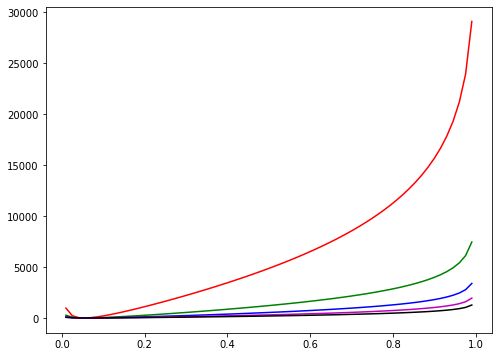

In [20]:
test_powers = np.linspace(0.01,.99,66)
samples = []
colors = ['r','g','b','m','k']
for i in np.linspace(0.11,0.15,5):
    samples.append([sample_size.find_sample_size(p_control = 0.1, p_treatment = i, power = x, alpha = 0.05) for x in test_powers])
               
fig, ax = plt.subplots(1,1,figsize = (8,6))

for i, color in zip(samples, colors):
    ax.plot(test_powers, i, color = color)

plt.show();